# lib

In [13]:
import sentencepiece as spm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# vocab

In [3]:
vocab_file = "news2.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

# text를 tensor로 변환(텍스트 데이터를 숫자로 allow computer to understand text)
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

['▁', '겨울은', '▁', '추워요', '.']
['▁', '감기', '▁', '조심하세요', '.']
torch.Size([2, 5])
tensor([[7921,    1, 7921,    1, 7942],
        [7921,    1, 7921,    1, 7942]])


# embedding
transformer uses input embedding and position embedding

## input embedding
입력 텍스트(단어, 문장 등)를 모델이 이해할 수 있는 숫자 벡터로 변환하는 과정

In [6]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([2, 5, 128])


## position embedding
: Transformer 모델에서 입력 시퀀스 내에서 각 단어의 위치 정보를 모델에 전달하기 위해 사용되는 방법. 

- 각 position별도 angle 값을 구합니다.
- 구해진 angle 중 짝수 index의 값에 대한 sin 값을 구합니다.
- 구해진 angle 중 홀수 index의 값에 대한 cos 값을 구합니다.

In [10]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn): # apply sin & cos func to position embedding
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position): # create embedding vetors
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    # calculate vectors of each position and make it as a table
    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    # 최종 임베딩 테이블 생성
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

(64, 128)


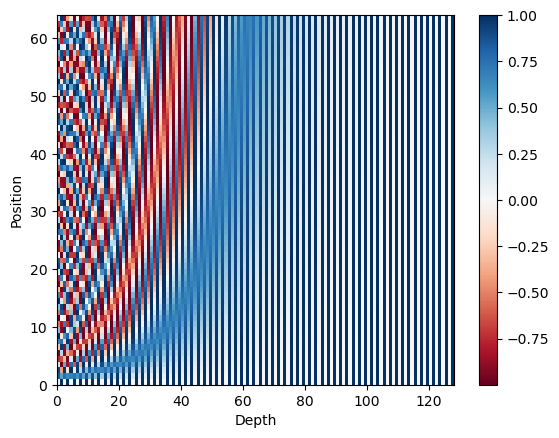

In [14]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

아래 절차로 position embedding 값을 구합니다.

0) position encoding : sin and cos 함수를 사용해 미리 계산된 위치 정보. 이는 모델이 입력 시퀀스 내에서 단어의 순서를 이해하도록 한다.
1) 위해서 구해진 position encoding 값을 이용해 position emgedding을 생성합니다. 학습되는 값이 아니므로 freeze옵션을 True로 설정합니다.
2) 입력 inputs과 동일한 크기를 갖는 positions값을 구합니다.
3) input값 중 pad(0)값을 찾습니다.
4) positions값중 pad부분은 0으로 변경 합니다. (패딩이 있는 부분은 위치 정보가 필요 없으므로, 해당 위치의 인덱스를 0으로 설정합니다.)
5) positions값에 해당하는 embedding값을 구합니다.

In [15]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[7921,    1, 7921,    1, 7942],
        [7921,    1, 7921,    1, 7942]])
tensor([[1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5]])
torch.Size([2, 5, 128])


In [16]:
input_sums = input_embs + pos_embs

# scaled dot product attention
: Transformer 모델에서 사용하는 주목(attention) 메커니즘 중 하나로, 입력된 정보들 중에서 특정 부분에 더 집중하게 하는 방법. 문장 내에서 단어들 간의 관계를 잘 이해하게 해줌.

입력값은 Q(query), K(key), V(value) 그리고 attention mask로 구성 되어 있습니다. 입력값 중 K, V는 같은 값 이어야 합니다.
Q, K, V가 모두 동일한 경우는 self attention이라 합니다.

<img src="https://paul-hyun.github.io/assets/2019-12-19/scale_dot_product_attention.png">

In [17]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 5, 5])
tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]])


In [20]:
# (1) Q * K-transpose
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0]) # 각 단어 상호 간에 가중치를 표현하는 테이블 생성

torch.Size([2, 5, 5])
tensor([[172.7438,  59.6595, 169.0671,  53.8206,  54.9349],
        [ 59.6595, 171.9738,  61.2613, 168.1869,  67.7811],
        [169.0671,  61.2613, 178.6267,  65.3298,  63.0629],
        [ 53.8206, 168.1869,  65.3298, 177.6362,  80.0556],
        [ 54.9349,  67.7811,  63.0629,  80.0556, 219.7572]],
       grad_fn=<SelectBackward0>)


In [22]:
# (2) scale
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0]) # 편차가 줆

torch.Size([2, 5, 5])
tensor([[2.6991, 0.9322, 2.6417, 0.8409, 0.8584],
        [0.9322, 2.6871, 0.9572, 2.6279, 1.0591],
        [2.6417, 0.9572, 2.7910, 1.0208, 0.9854],
        [0.8409, 2.6279, 1.0208, 2.7756, 1.2509],
        [0.8584, 1.0591, 0.9854, 1.2509, 3.4337]], grad_fn=<SelectBackward0>)


In [23]:
# (3) mask
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

torch.Size([2, 5, 5])
tensor([[2.6991, 0.9322, 2.6417, 0.8409, 0.8584],
        [0.9322, 2.6871, 0.9572, 2.6279, 1.0591],
        [2.6417, 0.9572, 2.7910, 1.0208, 0.9854],
        [0.8409, 2.6279, 1.0208, 2.7756, 1.2509],
        [0.8584, 1.0591, 0.9854, 1.2509, 3.4337]], grad_fn=<SelectBackward0>)


In [24]:
# (4) softmax
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 5, 5])
tensor([[0.4116, 0.0703, 0.3886, 0.0642, 0.0653],
        [0.0695, 0.4018, 0.0712, 0.3787, 0.0789],
        [0.3656, 0.0678, 0.4245, 0.0723, 0.0698],
        [0.0603, 0.3598, 0.0721, 0.4170, 0.0908],
        [0.0556, 0.0680, 0.0632, 0.0824, 0.7308]], grad_fn=<SelectBackward0>)


In [25]:
# (5) attn_prov*V
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 5, 128])


In [26]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

# Multi-head attention
Q, K, V, attn_mask는 ScaledDotProductAttention과 동일 합니다.
head 개수는 2개 head의 dimension은 64 입니다.